In [21]:
import os
num_threads = "8"
os.environ["OMP_NUM_THREADS"] = num_threads
os.environ["OPENBLAS_NUM_THREADS"] = num_threads
os.environ["MKL_NUM_THREADS"] = num_threads
os.environ["VECLIB_MAXIMUM_THREADS"] = num_threads
os.environ["NUMEXPR_NUM_THREADS"] = num_threads

import numpy as np
import scipy as sp
import scanpy as sc
import anndata as ad
import pandas as pd
import os
import matplotlib.pyplot as plt
import sys
sys.path.append("../src/")
import util
import scvelo as scv
import rf
import torch

PLT_CELL = 3.5

In [6]:
import glob
DATA_PATH = "../data/simulation/Curated/"
i = 1
paths = glob.glob(os.path.join(DATA_PATH, f"HSC*/HSC*-{i}"))
names = [os.path.basename(p).split("-")[0] for p in paths]
adatas = [util.load_adata(p) for p in paths]

T = 5
t_bins = np.linspace(0, 1, T+1)[:-1]
def bin_timepoints(adata):
    adata.obs["t"] = np.digitize(adata.obs.t_sim, t_bins)-1
for adata in adatas:
    bin_timepoints(adata)

In [7]:
kos = []
for p in paths:
    try:
        kos.append(os.path.basename(p).split('_ko_')[1].split("-")[0])
    except:
        kos.append(None)
kos

['Eklf', 'Gata1', 'EgrNab', 'Fli1', 'Gfi1', None, 'Fog1', 'Scl', 'cJun']

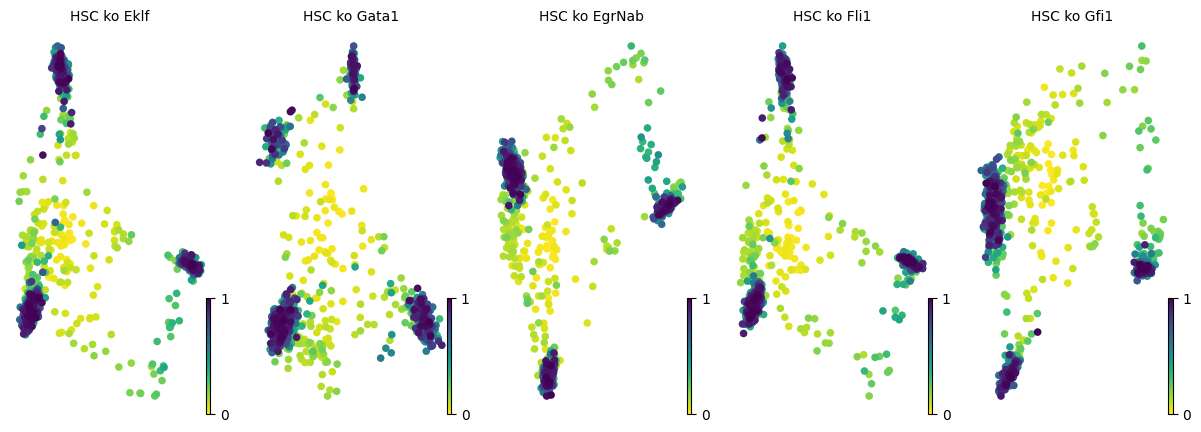

In [11]:
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i, (adata, name) in enumerate(zip(adatas[:5], names[:5])):
    scv.pl.scatter(adata, basis = "pca", color = "t_sim", title = name, ax = axs[i], show = False)

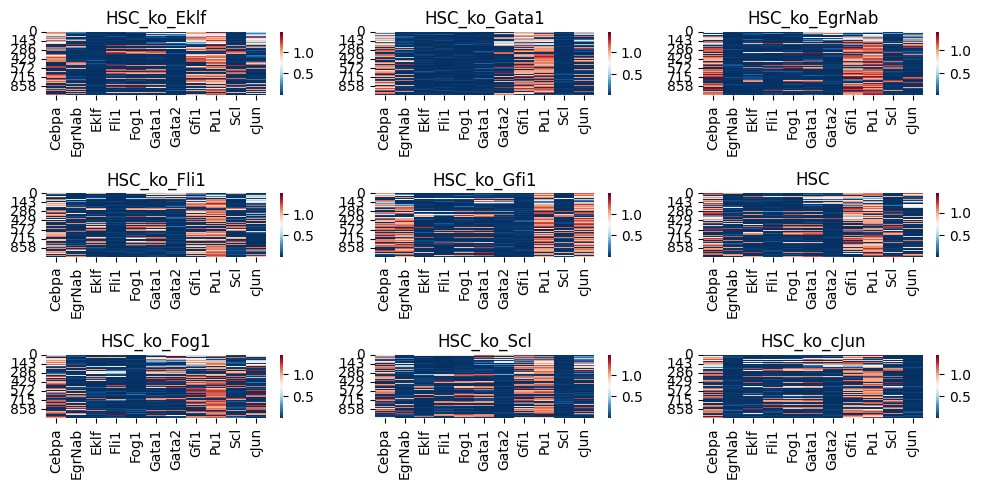

In [12]:
import seaborn as sb
plt.figure(figsize = (10, 6))
for i, (adata, name) in enumerate(zip(adatas, names)):
    plt.subplot(4, 3, i+1)
    sb.heatmap(pd.DataFrame(adata.X[np.argsort(adata.obs.t), :], columns = adata.var.index), cmap = "RdBu_r")
    plt.title(name)
    plt.axis("auto")
plt.tight_layout()

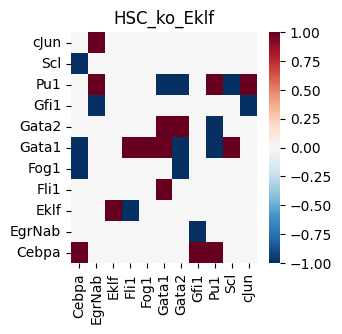

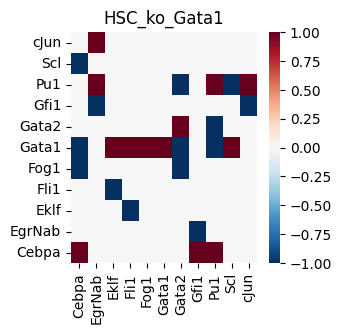

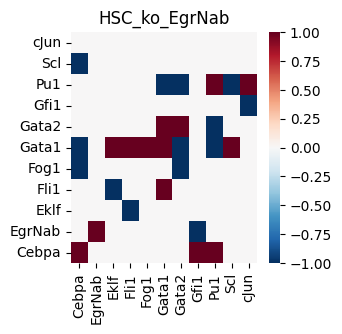

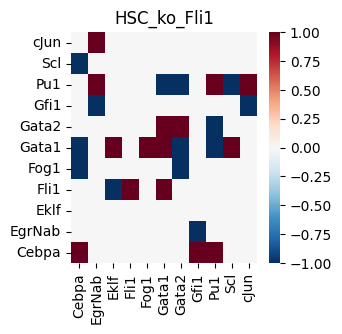

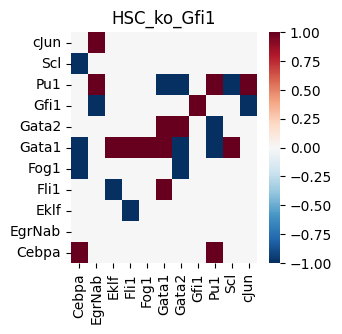

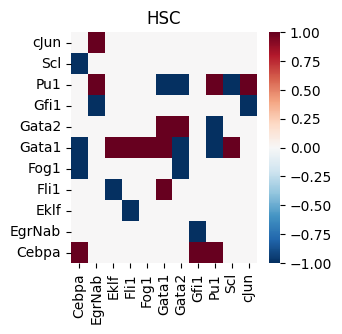

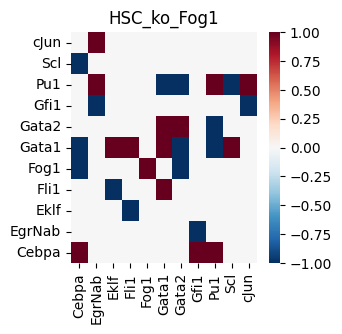

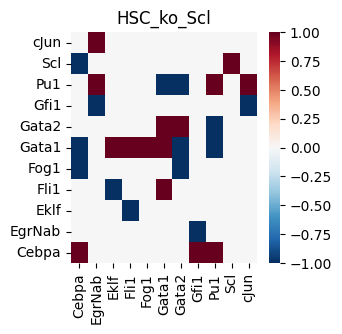

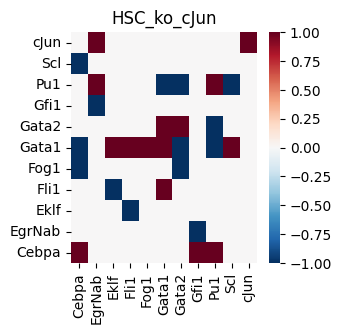

In [13]:
A_refs = []
for p, name in zip(paths, names):
    df = pd.read_csv(os.path.join(os.path.dirname(p), "refNetwork.csv"))
    n_genes = adata.shape[1]
    A_ref = pd.DataFrame(np.zeros((n_genes, n_genes), int), index = adata.var.index, columns=adata.var.index)
    for i in range(df.shape[0]):
        _i = df.iloc[i, 1]
        _j = df.iloc[i, 0]
        _v = {"+" : 1, "-" : -1}[df.iloc[i, 2]]
        A_ref.loc[_i, _j] = _v
    plt.figure(figsize = (3, 3));
    sb.heatmap(A_ref, vmin = -1, vmax = 1, cmap = "RdBu_r"); plt.gca().invert_yaxis()
    plt.title(name)
    A_refs.append(A_ref)

In [32]:
import networkx as nx
_A = A_refs[np.where(np.array(kos) == None)[0][0]]
np.fill_diagonal(_A.values, 0)
g = nx.DiGraph(_A)
centralities = nx.centrality.eigenvector_centrality(g.reverse())

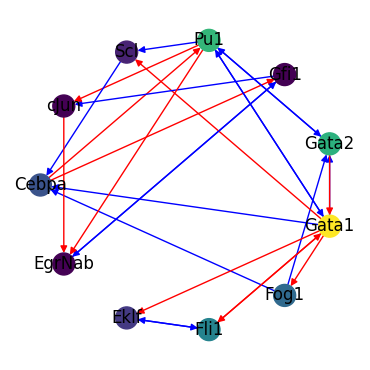

In [33]:
nx.set_node_attributes(g, centralities, name = "centrality")
plt.figure(figsize = (PLT_CELL, PLT_CELL))
edge_colors = ['red' if g[u][v]['weight'] > 0 else 'blue' for u, v in g.edges()]
nx.draw(g, with_labels = True, node_color = [centralities[x] for x in g.nodes], edge_color = edge_colors, node_size = 2.5e2, pos=nx.shell_layout(g))
plt.tight_layout()

In [54]:
centralities = pd.Series(centralities)
ko_genes = centralities.index[np.argsort(np.array(centralities))[::-1]][:8]
ko_idx = [np.where(np.array(kos) == None)[0][0], ]
for x in ko_genes:
    try:
        ko_idx.append(np.where(np.array(kos) == x)[0][0])
    except:
        pass
ko_idx

[5, 1, 3, 6, 0, 7]

In [56]:
[kos[i] for i in ko_idx]

[None, 'Gata1', 'Fli1', 'Fog1', 'Eklf', 'Scl']

In [57]:
options = {
    "lr" : 0.1, 
    "reg_sinkhorn" : 0.1,
    "reg_A" : 1e-3, 
    "reg_A_elastic" : 0, 
    "iter" : 1000,
    "ot_coupling" : True,
    "optimizer" : torch.optim.Adam,
    "n_pca_components" : -1
}
# estim_joint = rf.Estimator([adatas[i] for i in ko_idx], [kos[i] for i in ko_idx], 
#                            lr = options["lr"],
#                            reg_sinkhorn = options["reg_sinkhorn"], 
#                            reg_A = options["reg_A"], 
#                            reg_A_elastic = options["reg_A_elastic"], 
#                            iter = options["iter"], 
#                            ot_coupling = options["ot_coupling"],
#                            optimizer = options["optimizer"])
# estim_joint.fit(print_iter=100, alg = "joint");

estim_alt = rf.Estimator([adatas[i] for i in ko_idx], [kos[i] for i in ko_idx], 
                           lr = options["lr"],
                           reg_sinkhorn = options["reg_sinkhorn"], 
                           reg_A = options["reg_A"], 
                           reg_A_elastic = options["reg_A_elastic"], 
                           iter = options["iter"], 
                           ot_coupling = options["ot_coupling"],
                           optimizer = options["optimizer"], 
                           n_pca_components = options["n_pca_components"])
estim_alt.fit(print_iter=100, alg = "alternating", update_couplings_iter=250);

Updating transport plans
iteration 0, loss = -2.9544777198339323, L = -2.9544777198339323, R = 0.0
iteration 100, loss = -3.0518709626223917, L = -3.0906145754429755, R = 38.74361282058376
iteration 200, loss = -3.0519235075536306, L = -3.0913934647011416, R = 39.46995714751116
iteration 300, loss = -3.0649217392080126, L = -3.1096612698962542, R = 44.73953068824163
iteration 400, loss = -3.0649943423604347, L = -3.10996257190595, R = 44.96822954551549
iteration 500, loss = -3.065843656485525, L = -3.110966592656825, R = 45.122936171299614
iteration 600, loss = -3.0660275445773206, L = -3.112760145316299, R = 46.732600738978476
iteration 700, loss = -3.0661599246533044, L = -3.112848769180658, R = 46.6888445273533
iteration 800, loss = -3.066107927268038, L = -3.1134172412638867, R = 47.3093139958488
iteration 900, loss = -3.066177806433918, L = -3.1133829943108684, R = 47.20518787695045


In [24]:
estim_alt_wt = rf.Estimator([adatas[i] for i in ko_idx[:1]], [kos[i] for i in ko_idx[:1]], 
                           lr = options["lr"],
                           reg_sinkhorn = options["reg_sinkhorn"], 
                           reg_A = options["reg_A"], 
                           reg_A_elastic = options["reg_A_elastic"], 
                           iter = options["iter"], 
                           ot_coupling = options["ot_coupling"],
                           optimizer = options["optimizer"])
estim_alt_wt.fit(print_iter=100, alg = "alternating", update_couplings_iter=250);

Updating transport plans
iteration 0, loss = -3.217448248817905, L = -3.217448248817905, R = 0.0
iteration 100, loss = -3.366809985018309, L = -3.4078576250790684, R = 41.047640060759484
iteration 200, loss = -3.367167710101693, L = -3.4091542653537266, R = 41.986555252033654
iteration 300, loss = -3.3836841395708808, L = -3.431276632920521, R = 47.59249334964005
iteration 400, loss = -3.3840295074755344, L = -3.4324788567776277, R = 48.449349302093246
iteration 500, loss = -3.3866105628594143, L = -3.4352734782508687, R = 48.662915391454575
iteration 600, loss = -3.387908013392823, L = -3.4385820864285304, R = 50.67407303570729
iteration 700, loss = -3.387860515539095, L = -3.4388311121227817, R = 50.97059658368694
iteration 800, loss = -3.3882412449269586, L = -3.4400754174814683, R = 51.83417255450976
iteration 900, loss = -3.388269904473524, L = -3.439945076811598, R = 51.6751723380738


In [58]:
A_ref = A_refs[np.where(np.array(kos) == None)[0][0]].to_numpy(); np.fill_diagonal(A_ref, 0)

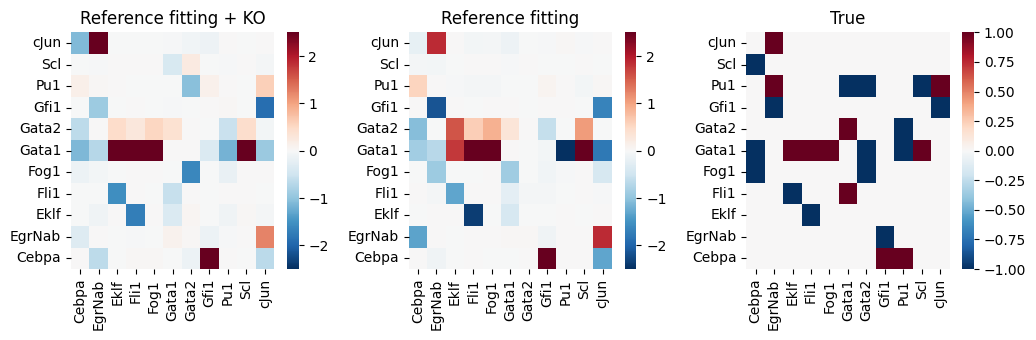

In [59]:
plt.figure(figsize = (3*PLT_CELL, PLT_CELL))
plt.subplot(1, 3, 1)
sb.heatmap(pd.DataFrame(estim_alt.A, index = adatas[0].var.index, columns = adatas[0].var.index), vmin = -2.5, vmax = 2.5, cmap = "RdBu_r")
plt.gca().invert_yaxis()
plt.title("Reference fitting + KO")
plt.subplot(1, 3, 2)
sb.heatmap(pd.DataFrame(estim_alt_wt.A, index = adatas[0].var.index, columns = adatas[0].var.index), vmin = -2.5, vmax = 2.5, cmap = "RdBu_r")
plt.gca().invert_yaxis()
plt.title("Reference fitting")
plt.subplot(1, 3, 3)
sb.heatmap(pd.DataFrame(A_ref, index = adatas[0].var.index, columns = adatas[0].var.index), vmin = -1.0, vmax = 1.0, cmap = "RdBu_r")
plt.gca().invert_yaxis()
plt.title("True")
plt.tight_layout()

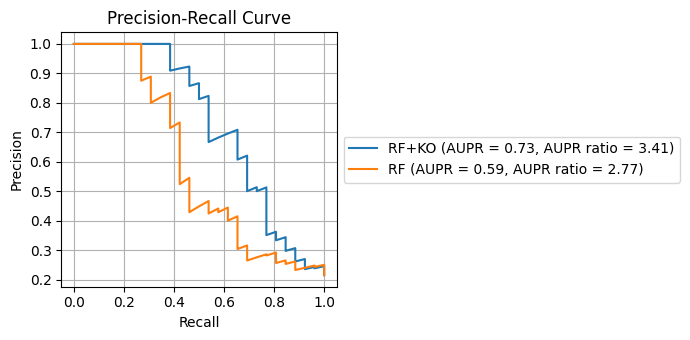

In [60]:
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score
ys = {}
y_true = np.abs(np.sign(A_ref).astype(int).flatten())
ys["RF+KO"] = np.abs(estim_alt.A.flatten())
ys["RF"] = np.abs(estim_alt_wt.A.flatten())

plt.figure(figsize=(2*PLT_CELL, PLT_CELL))
for (k, y) in ys.items():
    prec, rec, thresh = precision_recall_curve(y_true, y)
    avg_prec = average_precision_score(y_true, y)
    plt.plot(rec, prec, label=f'{k} (AUPR = {avg_prec:.2f}, AUPR ratio = {avg_prec / y_true.mean():.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()